<h1>Обучение многовходовой модели обнаружения аномалий</h1>

In [1]:
import numpy as np
np.set_printoptions(threshold=np.inf)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras import optimizers


dir = os.getcwd()
import time
from pickle import load, dump

import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline 

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix

import winsound
from datetime import datetime
from rnn_training import *
from cf_matrix import *
from VAD import VAD

from scipy.signal import medfilt, wiener
import math

<h2>Импорт и отображение данных</h2>

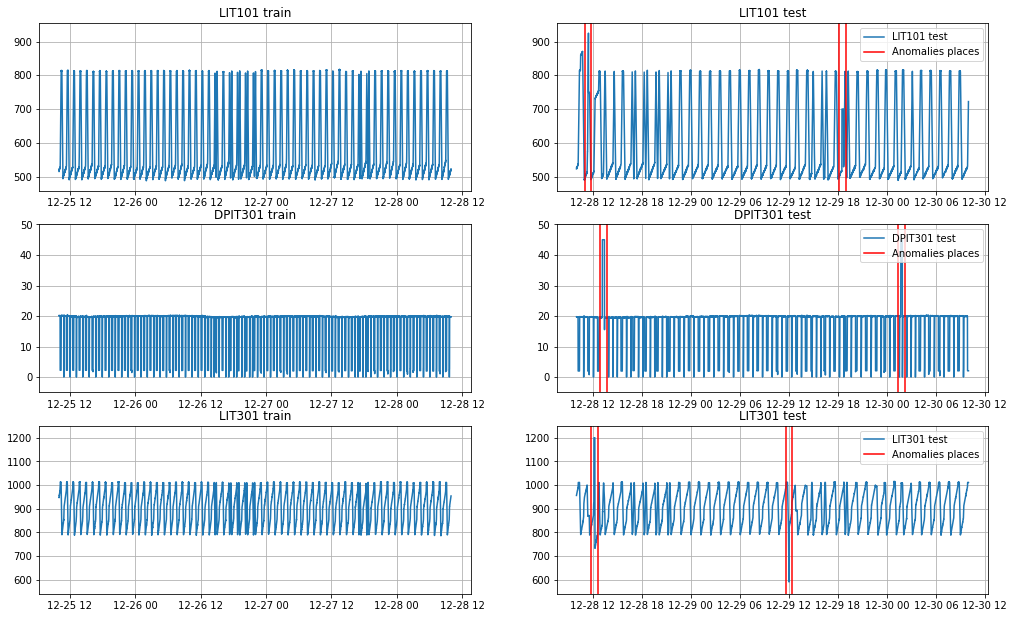

In [2]:
train_dataframe = pd.read_csv("Train.csv", usecols=[1,2,3])
train_dateindex = pd.date_range("2015-12-25 10:00:00", 
                                periods=train_dataframe.shape[0], freq="s")
train_dataframe.index = train_dateindex

test_dataframe = pd.read_csv("Test.csv", usecols=[1,3,5])
labels_dataframe = pd.read_csv("Test.csv", usecols=[2,4,6,7])
test_dateindex = pd.date_range("2015-12-28 10:00:00",
                               periods=test_dataframe.shape[0], freq="s")
test_dataframe.index = test_dateindex
labels_dataframe.index = test_dateindex

train_dataframe = train_dataframe.resample('30s').first()
test_dataframe = test_dataframe.resample('30S').first()
labels_dataframe = labels_dataframe.resample('30S').first()

anomal_dateindex_1 =  pd.to_datetime(["28.12.2015 11:20:09", "28.12.2015 11:28:02",
                                      "29.12.2015 18:29:59", "29.12.2015 18:41:40"])
anomal_dateindex_2 =  pd.to_datetime(["28.12.2015 13:09:45", "28.12.2015 13:25:54",
                                      "30.12.2015 01:42:07", "30.12.2015 01:53:30"])
anomal_dateindex_3 =  pd.to_datetime(["28.12.2015 12:08:15", "28.12.2015 12:15:12",
                                      "29.12.2015 11:57:04", "29.12.2015 12:01:44"])

redline_dateindex_1 =  pd.to_datetime(["28.12.2015 11:00:09", "28.12.2015 11:48:02",
                                      "29.12.2015 18:09:59", "29.12.2015 19:01:40"])
redline_dateindex_2 =  pd.to_datetime(["28.12.2015 12:49:45", "28.12.2015 13:45:54",
                                      "30.12.2015 01:22:07", "30.12.2015 02:13:30"])
redline_dateindex_3 =  pd.to_datetime(["28.12.2015 11:48:15", "28.12.2015 12:35:12",
                                      "29.12.2015 11:37:04", "29.12.2015 12:21:44"])

min_1 = min(train_dataframe['LIT101'].min(), test_dataframe['LIT101'].min()) - 30
max_1 = max(train_dataframe['LIT101'].max(), test_dataframe['LIT101'].max()) + 30

min_2 = min(train_dataframe['DPIT301'].min(), test_dataframe['DPIT301'].min()) - 5
max_2 = max(train_dataframe['DPIT301'].max(), test_dataframe['DPIT301'].max()) + 5

min_3 = min(train_dataframe['LIT301'].min(), test_dataframe['LIT301'].min()) - 50
max_3 = max(train_dataframe['LIT301'].max(), test_dataframe['LIT301'].max()) + 50

plt.figure(figsize=(17, 10.5))
plt.subplot(321)
plt.plot(train_dataframe['LIT101'])
plt.title('LIT101 train')
plt.ylim(min_1,max_1)
plt.grid()

plt.subplot(322)
plt.plot(test_dataframe['LIT101'])
for ind in redline_dateindex_1:
    plt.axvline(x=ind,color='r')
plt.title('LIT101 test')
plt.ylim(min_1,max_1)
legend_elements = [Line2D([0], [0], color='tab:blue', label='LIT101 test'),
                   Line2D([0], [0], color='r', label='Anomalies places')]
plt.legend(handles=legend_elements, loc=1)
plt.grid()

plt.subplot(323)
plt.plot(train_dataframe['DPIT301'])
plt.title('DPIT301 train')
plt.ylim(min_2,max_2)
plt.grid()

plt.subplot(324)
plt.plot(test_dataframe['DPIT301'])
for ind in redline_dateindex_2:
    plt.axvline(x=ind,color='r')
plt.title('DPIT301 test')
plt.ylim(min_2,max_2)
legend_elements = [Line2D([0], [0], color='tab:blue', label='DPIT301 test'),
                   Line2D([0], [0], color='r', label='Anomalies places')]
plt.legend(handles=legend_elements, loc=1)
plt.grid()

plt.subplot(325)
plt.plot(train_dataframe['LIT301'])
plt.title('LIT301 train')
plt.ylim(min_3,max_3)
plt.grid()

plt.subplot(326)
plt.plot(test_dataframe['LIT301'])
for ind in redline_dateindex_3:
    plt.axvline(x=ind,color='r')
plt.title('LIT301 test')
plt.ylim(min_3,max_3)
legend_elements = [Line2D([0], [0], color='tab:blue', label='LIT301 test'),
                   Line2D([0], [0], color='r', label='Anomalies places')]
plt.legend(handles=legend_elements, loc=1)
plt.grid()
plt.savefig('Models//Multisignal//multisignal train&test', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', pad_inches=0.1)
plt.show()

<h2>Приведение данных к масштабу [0,1]
и отображение масштабированных данных</h2>

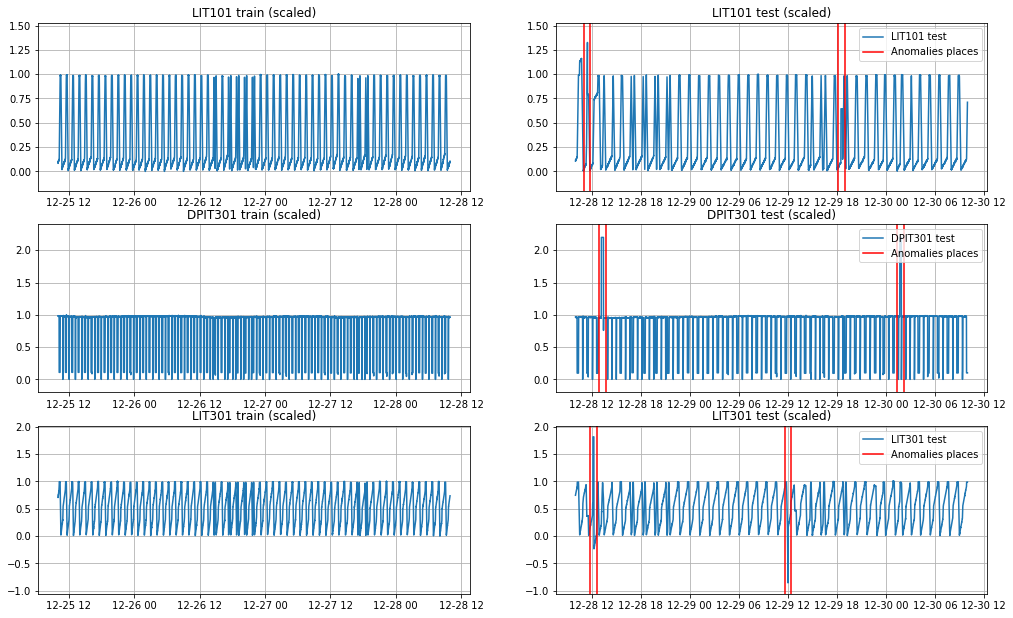

In [3]:
scaler = MinMaxScaler()
scaler.fit(train_dataframe)

train_dataframe = pd.DataFrame(data = scaler.transform(train_dataframe),
                               columns=train_dataframe.columns,
                               index = train_dataframe.index)
test_dataframe = pd.DataFrame(scaler.transform(test_dataframe),
                              columns=test_dataframe.columns,
                              index = test_dataframe.index)

min_1 = min(train_dataframe['LIT101'].min(), test_dataframe['LIT101'].min()) - 0.2
max_1 = max(train_dataframe['LIT101'].max(), test_dataframe['LIT101'].max()) + 0.2

min_2 = min(train_dataframe['DPIT301'].min(), test_dataframe['DPIT301'].min()) - 0.2
max_2 = max(train_dataframe['DPIT301'].max(), test_dataframe['DPIT301'].max()) + 0.2

min_3 = min(train_dataframe['LIT301'].min(), test_dataframe['LIT301'].min()) - 0.2
max_3 = max(train_dataframe['LIT301'].max(), test_dataframe['LIT301'].max()) + 0.2

plt.figure(figsize=(17, 10.5))
plt.subplot(321)
plt.plot(train_dataframe['LIT101'])
plt.title('LIT101 train (scaled)')
plt.ylim(min_1,max_1)
plt.grid()

plt.subplot(322)
plt.plot(test_dataframe['LIT101'])
for ind in redline_dateindex_1:
    plt.axvline(x=ind,color='r')
plt.title('LIT101 test (scaled)')
plt.ylim(min_1,max_1)
legend_elements = [Line2D([0], [0], color='tab:blue', label='LIT101 test'),
                   Line2D([0], [0], color='r', label='Anomalies places')]
plt.legend(handles=legend_elements, loc=1)
plt.grid()

plt.subplot(323)
plt.plot(train_dataframe['DPIT301'])
plt.title('DPIT301 train (scaled)')
plt.ylim(min_2,max_2)
plt.grid()

plt.subplot(324)
plt.plot(test_dataframe['DPIT301'])
for ind in redline_dateindex_2:
    plt.axvline(x=ind,color='r')
plt.title('DPIT301 test (scaled)')
plt.ylim(min_2,max_2)
legend_elements = [Line2D([0], [0], color='tab:blue', label='DPIT301 test'),
                   Line2D([0], [0], color='r', label='Anomalies places')]
plt.legend(handles=legend_elements, loc=1)
plt.grid()

plt.subplot(325)
plt.plot(train_dataframe['LIT301'])
plt.title('LIT301 train (scaled)')
plt.ylim(min_3,max_3)
plt.grid()

plt.subplot(326)
plt.plot(test_dataframe['LIT301'])
for ind in redline_dateindex_3:
    plt.axvline(x=ind,color='r')
plt.title('LIT301 test (scaled)')
plt.ylim(min_3,max_3)
legend_elements = [Line2D([0], [0], color='tab:blue', label='LIT301 test'),
                   Line2D([0], [0], color='r', label='Anomalies places')]
plt.legend(handles=legend_elements, loc=1)
plt.grid()
plt.savefig('Models//Multisignal//multisignal train&test scaled', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', pad_inches=0.1)
plt.show()

<h2>Создание обучающих, валидационных и тестовых данных</h2>

In [4]:
train_X = train_dataframe[:-2880].to_numpy()                       
train_Y = train_X.copy()
train_data = np.concatenate((train_X, train_Y), axis=1).astype(np.float32)

valid_X = train_dataframe[-2880:].to_numpy() 
valid_Y = valid_X.copy()
valid_data = np.concatenate((valid_X, valid_Y), axis=1).astype(np.float32)

test_X = test_dataframe.to_numpy() 
test_Y = test_X.copy()
test_data = np.concatenate((test_X, test_Y), axis=1).astype(np.float32)

N = test_X.shape[1]

<h2>Задание параметров обучения, инициализация и обучение модели</h2>

In [5]:
num_neurons = 100
opt = optimizers.SGD()
loss = 'mean_squared_error'
num_epochs = 500

In [6]:
model, train_loss, val_loss, epochs, train_time = create_model(train_data = train_data, batch_size = 1,
                                                               neurons = num_neurons, opt = opt, loss_func = loss, out_dim = 3)

The training was completed in 1h 43m 14s (12.39 sec/epoch).


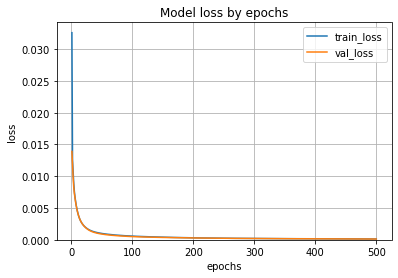

In [7]:
model, train_loss, val_loss, epochs, train_time = fit_rnn(model = model, train_data = train_data, val_data = valid_data,
                                                          nb_epoch = num_epochs, batch_size = 1,
                                                          train_loss = train_loss, val_loss = val_loss,
                                                          epochs = epochs, train_time = train_time, out_dim = 3)

<h2>Получение отклика модели на обучающих, валидационных и тестовых данных</h2>

In [8]:
predictions_train = np.zeros(shape = (len(train_data), 3))
for i in range(len(train_data)):
    X = train_data[i, 0:-3]
    yhat = forecast_rnn(model = model, batch_size = 1, X = X)
    predictions_train[i] = yhat
    
predictions_valid = np.zeros(shape = (len(valid_data), 3))
for i in range(len(valid_data)):
    X = valid_data[i, 0:-3]
    yhat = forecast_rnn(model = model, batch_size = 1, X = X)
    predictions_valid[i] = yhat
    
predictions_test = np.zeros(shape = (len(test_data), 3))
for i in range(len(test_data)):
    X = test_data[i, 0:-3]
    yhat = forecast_rnn(model = model, batch_size = 1, X = X)
    predictions_test[i] = yhat

<h2>Сохранение модели и откликов</h2>

In [9]:
model_directory = str(dir) + '\\Models\\Multisignal'
now_date = str(datetime.now().strftime("%Y-%m-%d_%H-%M"))

model.save(model_directory+'\\model_'+now_date)

with open(model_directory+'\\model_'+now_date+'\\train.predict', 'wb') as f:
    dump(predictions_train, f)
with open(model_directory+'\\model_'+now_date+'\\valid.predict', 'wb') as f:
    dump(predictions_valid, f)
with open(model_directory+'\\model_'+now_date+'\\test.predict', 'wb') as f:
    dump(predictions_test, f)

INFO:tensorflow:Assets written to: C:\Users\skolp\YandexDisk\УЧЕБА\ДИПЛОМ\SWaT\SWat A1\Models\Multisignal\model_2021-05-26_17-25\assets


INFO:tensorflow:Assets written to: C:\Users\skolp\YandexDisk\УЧЕБА\ДИПЛОМ\SWaT\SWat A1\Models\Multisignal\model_2021-05-26_17-25\assets


<h2>Загрузка модели и откликов</h2>

In [5]:
model_directory = str(dir) + '\\Models\\Multisignal'
model_input = input('Папка с моделью:')
model = load_model(model_directory+'\\'+model_input)
with open(model_directory+'\\'+model_input+'\\train.predict', 'rb') as f:
    predictions_train = load(f)
with open(model_directory+'\\'+model_input+'\\valid.predict', 'rb') as f:
    predictions_valid = load(f)
with open(model_directory+'\\'+model_input+'\\test.predict', 'rb') as f:
    predictions_test = load(f)
print('Модель и отклики загружены')

Папка с моделью:model_2021-05-26_17-25
Модель и отклики загружены


<h2>Отображение обучающих данных, отклика модели и ошибки отклика</h2>

In [6]:
error_train = train_Y - predictions_train
error_valid = valid_Y - predictions_valid
error_test = test_Y - predictions_test
anomal_thresholds = np.max(abs(error_train[10:, :]), axis = 0)

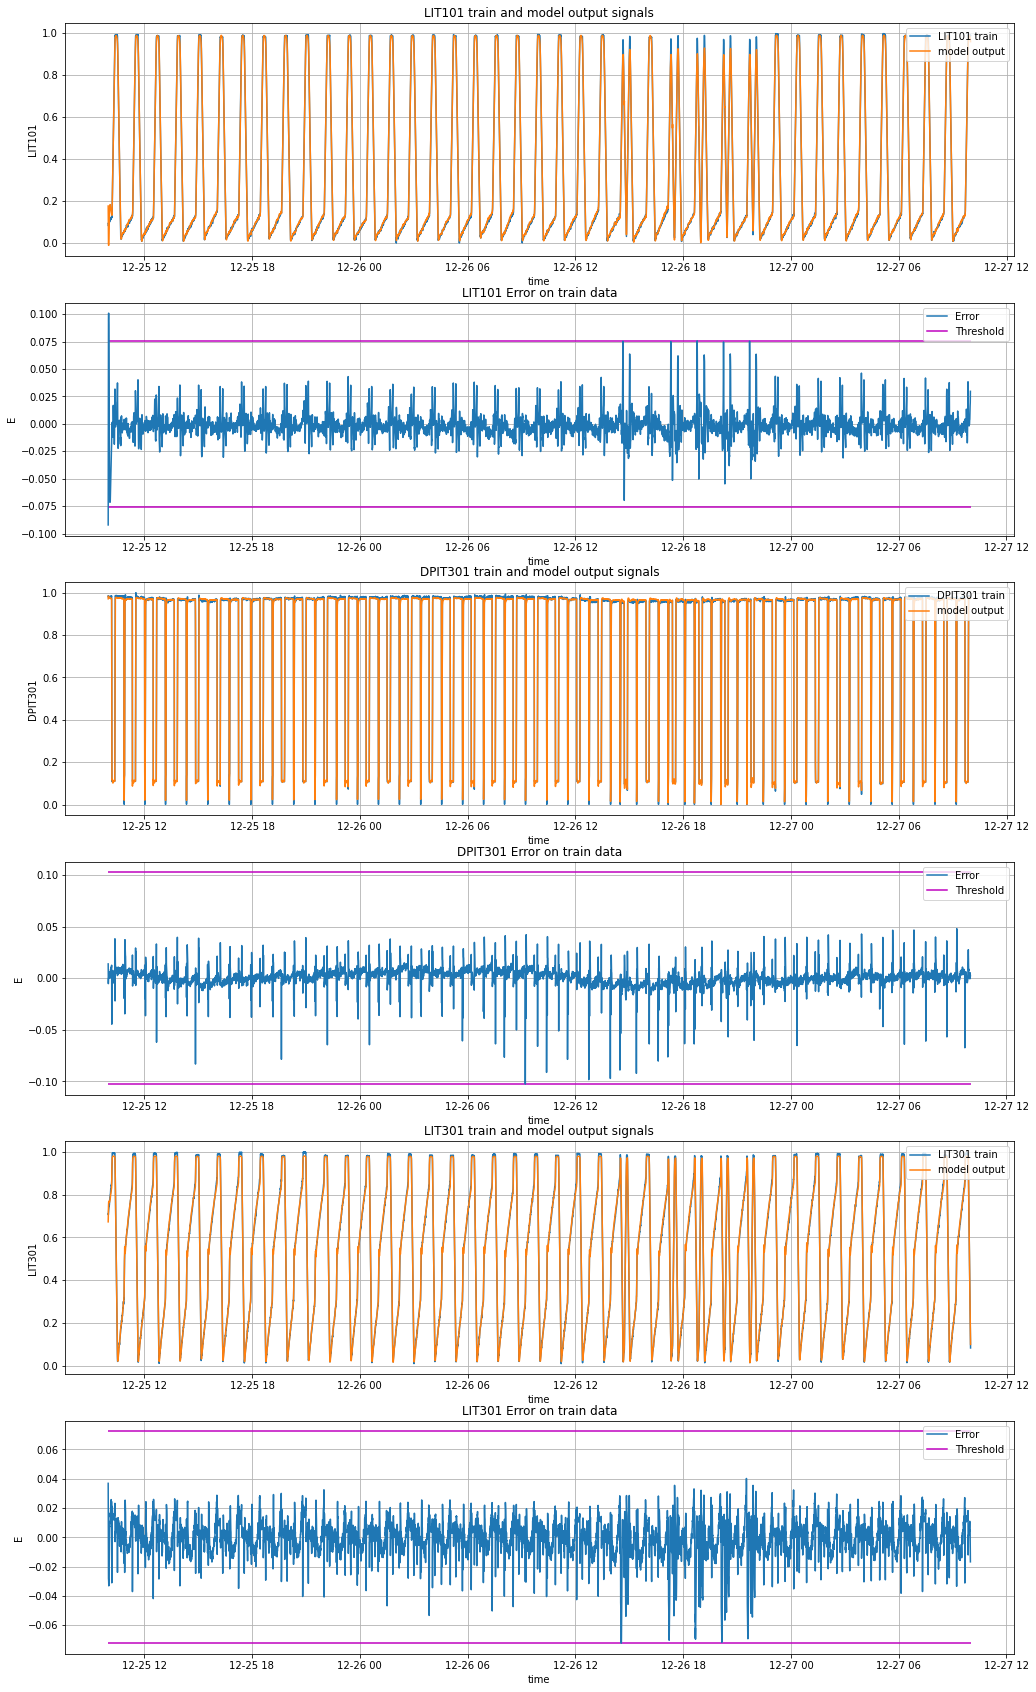

In [7]:
titles = ['LIT101', 'DPIT301', 'LIT301']
#train plot
# line plot of observed vs predicted
plt.figure(figsize=(17, 30))
for i in range(N):
    plt.subplot(611+2*i)
    plt.plot(train_dataframe.index[:-2880], train_data[:, i])
    plt.plot(train_dataframe.index[:-2880], predictions_train[:,i])
    plt.title(titles[i]+' train and model output signals')
    plt.ylabel(titles[i])
    plt.xlabel('time')
    plt.grid()
    plt.legend((titles[i]+' train','model output'), loc=1)

    plt.subplot(611+2*i+1)
    plt.plot(train_dataframe.index[:-2880], error_train[:,i])
    plt.hlines(anomal_thresholds[i], train_dataframe.index[0],
               train_dataframe.index[-2880], colors = 'm')
    plt.hlines(-anomal_thresholds[i], train_dataframe.index[0],
               train_dataframe.index[-2880], colors = 'm')
    plt.title(titles[i]+' Error on train data')
    plt.ylabel('E')
    plt.xlabel('time')
    plt.grid()
    legend_elements = [Line2D([0], [0], color='tab:blue', label='Error'),
                       Line2D([0], [0], color='m', label='Threshold')]
    plt.legend(handles=legend_elements, loc=1)

plt.savefig(model_directory+'\\'+model_input+'\\train+model+error', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', pad_inches=0.1)
plt.show()

<h2>Отображение валидационных данных, отклика модели и ошибки отклика</h2>

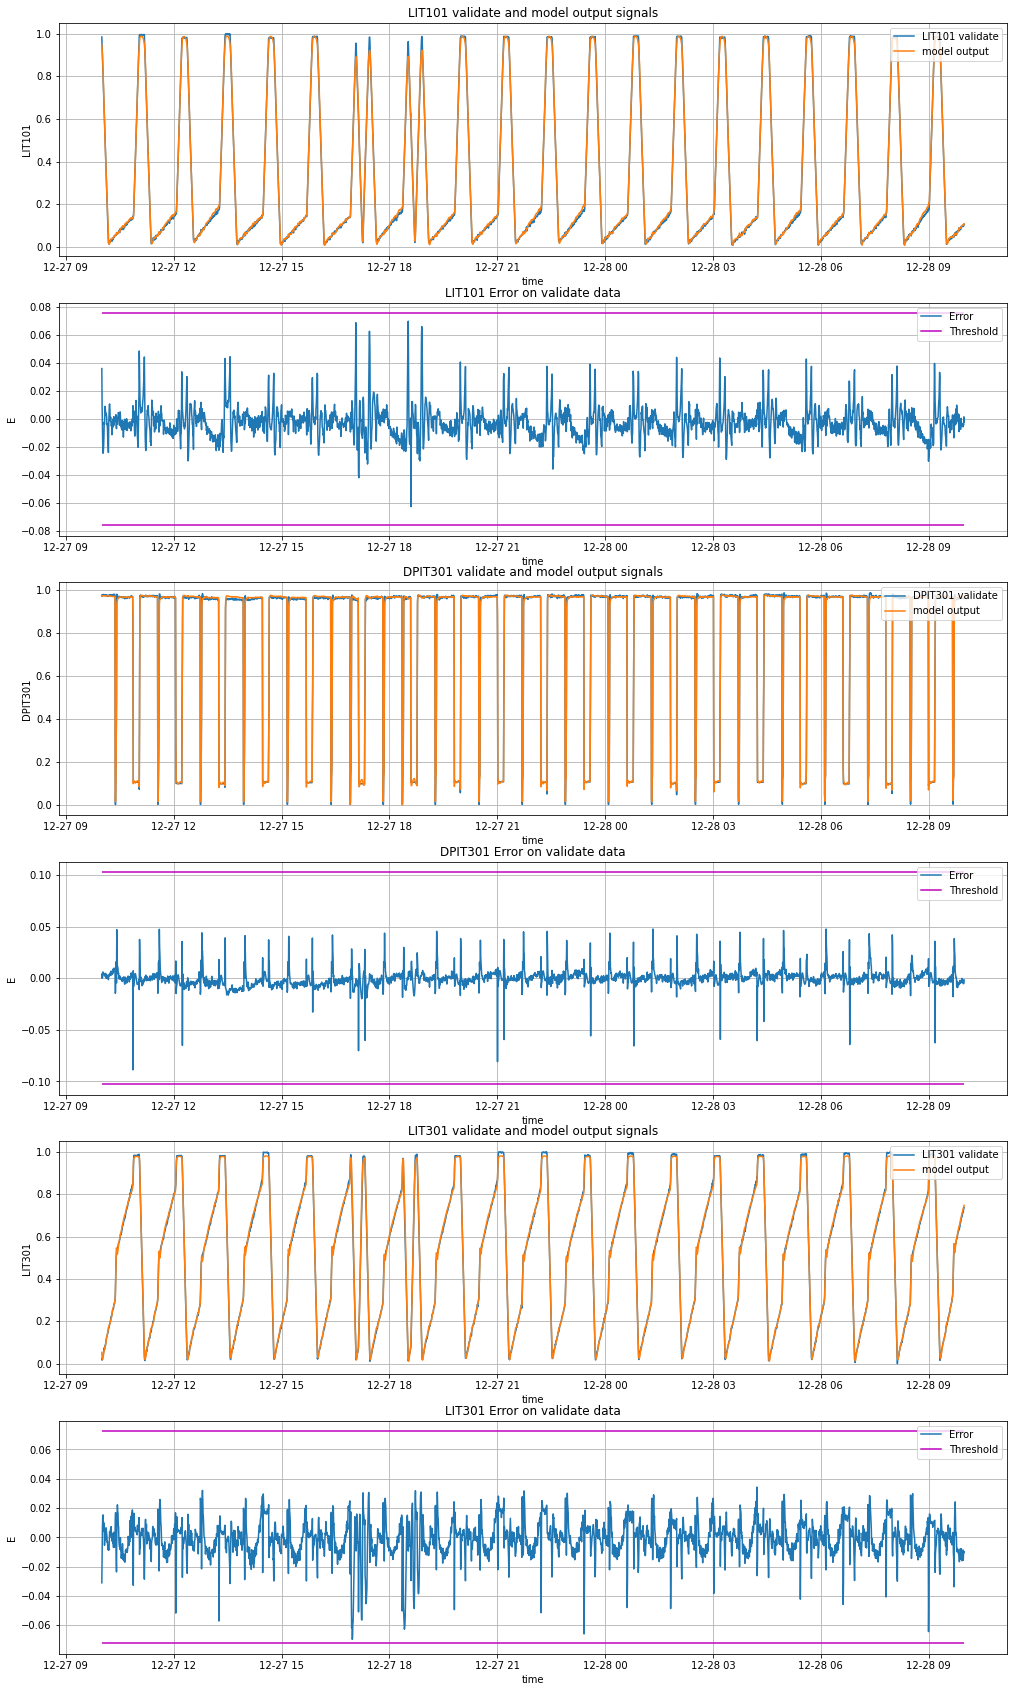

In [8]:
#Validate plot
# line plot of observed vs predicted
plt.figure(figsize=(17, 30))
for i in range(N):
    plt.subplot(611+2*i)
    plt.plot(train_dataframe.index[-2880:], valid_data[:, i])
    plt.plot(train_dataframe.index[-2880:], predictions_valid[:,i])
    plt.title(titles[i]+' validate and model output signals')
    plt.ylabel(titles[i])
    plt.xlabel('time')
    plt.grid()
    plt.legend((titles[i]+' validate','model output'), loc=1)

    plt.subplot(611+2*i+1)
    plt.plot(train_dataframe.index[-2880:], error_valid[:,i])
    plt.hlines(anomal_thresholds[i], train_dataframe.index[-2880],
               train_dataframe.index[-1],colors = 'm')
    plt.hlines(-anomal_thresholds[i], train_dataframe.index[-2880],
               train_dataframe.index[-1],colors = 'm')
    plt.title(titles[i]+' Error on validate data')
    plt.ylabel('E')
    plt.xlabel('time')
    plt.grid()
    legend_elements = [Line2D([0], [0], color='tab:blue', label='Error'),
                       Line2D([0], [0], color='m', label='Threshold')]
    plt.legend(handles=legend_elements, loc=1)

plt.savefig(model_directory+'\\'+model_input+'\\valid+model+error', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', pad_inches=0.1)
plt.show()

<h2>Отображение тестовых данных, отклика модели и ошибки отклика</h2>

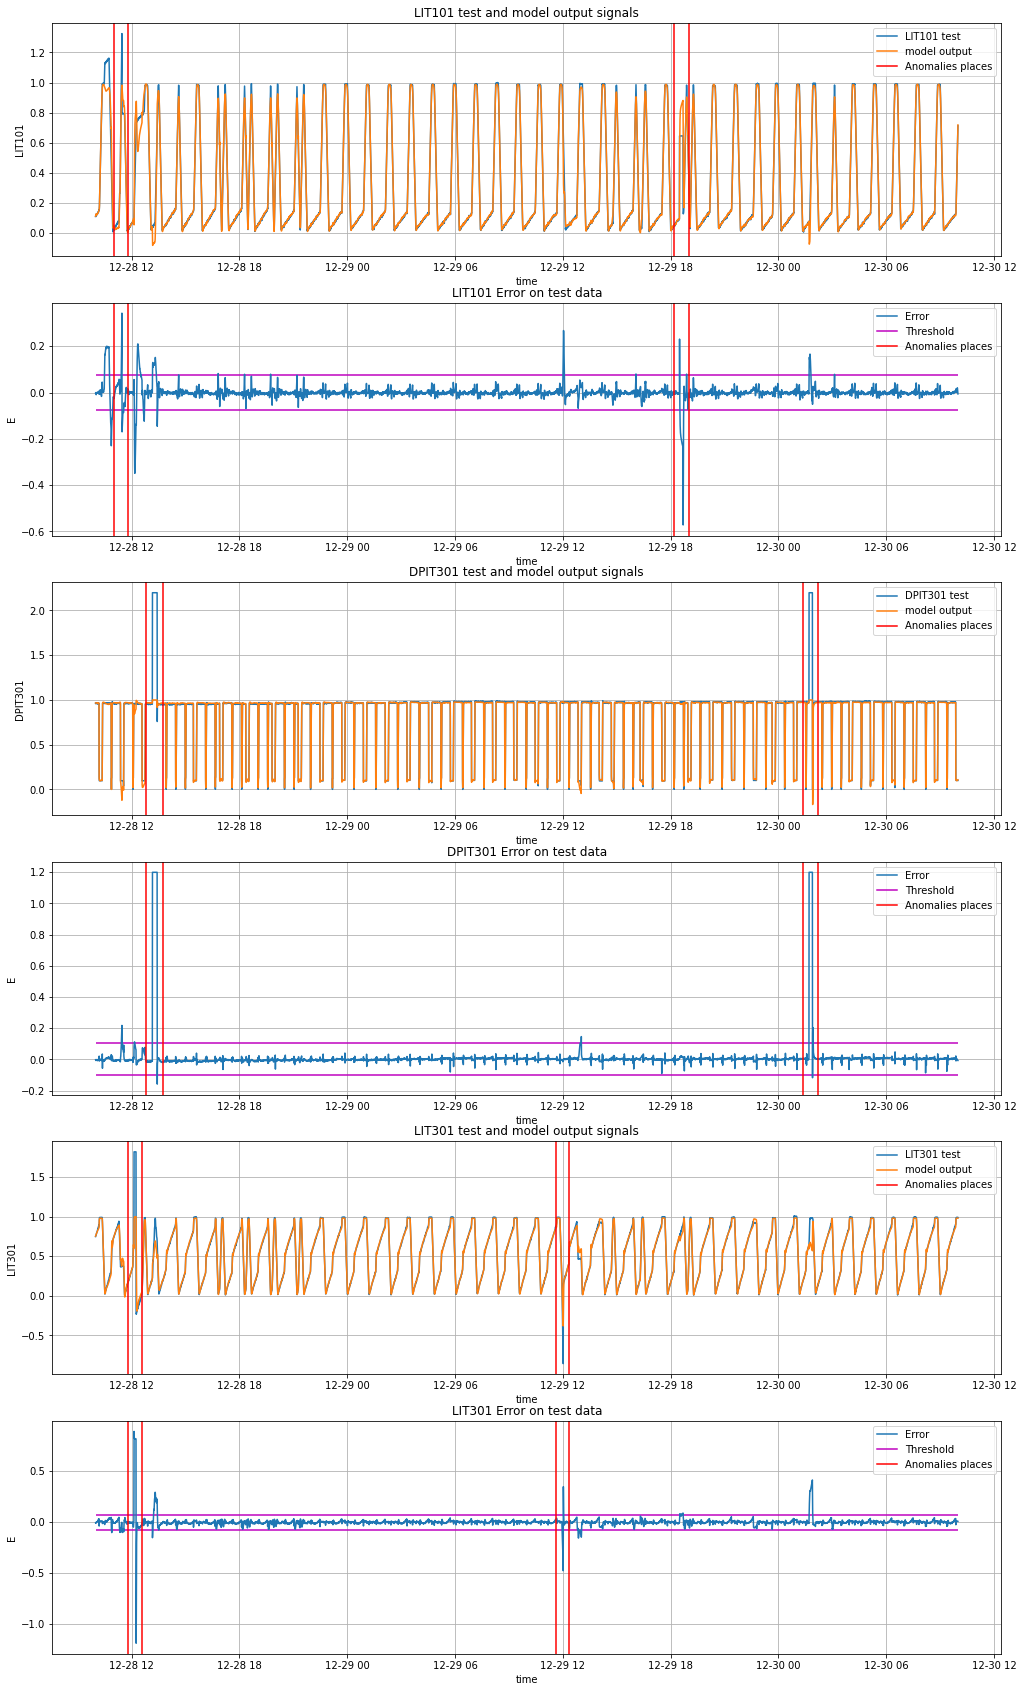

In [9]:
#test plot
# line plot of observed vs predicted
plt.figure(figsize=(17, 30))
for i in range(N):
    plt.subplot(611+2*i)
    plt.plot(test_dataframe.index, test_data[:, i])
    plt.plot(test_dataframe.index, predictions_test[:,i])
    if i == 0:
        for ind in redline_dateindex_1:
            plt.axvline(x=ind,color='r')
    if i == 1:
        for ind in redline_dateindex_2:
            plt.axvline(x=ind,color='r')
    if i == 2:
        for ind in redline_dateindex_3:
            plt.axvline(x=ind,color='r')
    plt.title(titles[i]+' test and model output signals')
    plt.ylabel(titles[i])
    plt.xlabel('time')
    plt.grid()
    legend_elements = [Line2D([0], [0], color='tab:blue', label=titles[i]+' test'),
                   Line2D([0], [0], color='tab:orange', label='model output'),
                   Line2D([0], [0], color='r', label='Anomalies places')]
    
    plt.legend(handles=legend_elements, loc=1)
    
    plt.subplot(611+2*i+1)
    plt.plot(test_dataframe.index, error_test[:,i])
    if i == 0:
        for ind in redline_dateindex_1:
            plt.axvline(x=ind,color='r')
    if i == 1:
        for ind in redline_dateindex_2:
            plt.axvline(x=ind,color='r')
    if i == 2:
        for ind in redline_dateindex_3:
            plt.axvline(x=ind,color='r')
    plt.hlines(anomal_thresholds[i], test_dataframe.index[0],
           test_dataframe.index[-1], colors = 'm', label='threshhold')
    plt.hlines(-anomal_thresholds[i], test_dataframe.index[0],
           test_dataframe.index[-1], colors = 'm', label='threshhold')
    plt.title(titles[i]+' Error on test data')
    plt.ylabel('E')
    plt.xlabel('time')
    plt.grid()
    legend_elements = [Line2D([0], [0], color='tab:blue', label='Error'),
                   Line2D([0], [0], color='m', label='Threshold'),
                   Line2D([0], [0], color='r', label='Anomalies places')]
    plt.legend(handles=legend_elements, loc=1)

plt.savefig(model_directory+'\\'+model_input+'\\test+model+error', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', pad_inches=0.1)
plt.show()

<h2>Метрики качества модели</h2>

              precision    recall  f1-score   support

      Anomal       0.14      0.68      0.23        40
      Normal       1.00      0.97      0.98      5720

    accuracy                           0.97      5760
   macro avg       0.57      0.82      0.61      5760
weighted avg       0.99      0.97      0.98      5760

              precision    recall  f1-score   support

      Anomal       0.70      1.00      0.82        55
      Normal       1.00      1.00      1.00      5705

    accuracy                           1.00      5760
   macro avg       0.85      1.00      0.91      5760
weighted avg       1.00      1.00      1.00      5760

              precision    recall  f1-score   support

      Anomal       0.16      0.96      0.27        23
      Normal       1.00      0.98      0.99      5737

    accuracy                           0.98      5760
   macro avg       0.58      0.97      0.63      5760
weighted avg       1.00      0.98      0.99      5760



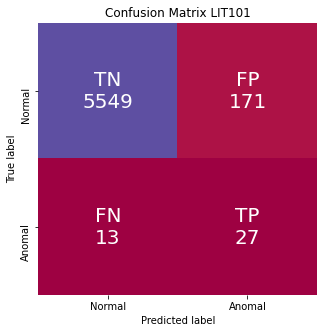

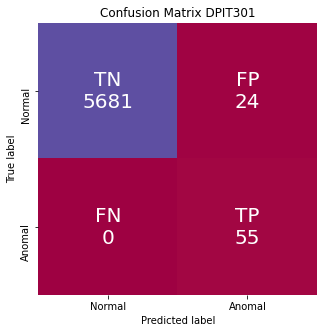

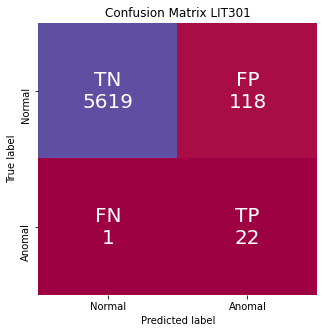

In [10]:
true_labels = labels_dataframe.to_numpy()[:,:-1]
model_labels = np.empty_like(true_labels)
for i in range(error_test.shape[0]):
    for j in range(error_test.shape[1]):
        if abs(error_test[i,j]) > anomal_thresholds[j]:
            model_labels[i,j] = 'Anomal'
        else: 
            model_labels[i,j] = 'Normal'

for i in range(N):
    cf_matrix = confusion_matrix(true_labels[:,i], model_labels[:,i], labels = ['Normal','Anomal'])
    make_confusion_matrix(cf_matrix,
                          f_name = model_directory+'\\'+model_input+'\\conf matrix '+titles[i],
                          group_names = ['TN','FP','FN','TP'],
                          categories = ['Normal', 'Anomal'],
                          percent = False,
                          cbar = False,
                          sum_stats = False,
                          cmap = 'Spectral',
                          figsize = (5,5),
                          title = 'Confusion Matrix '+titles[i])
    print(classification_report(true_labels[:,i], model_labels[:,i]))

<h2>Применение VAD</h2>

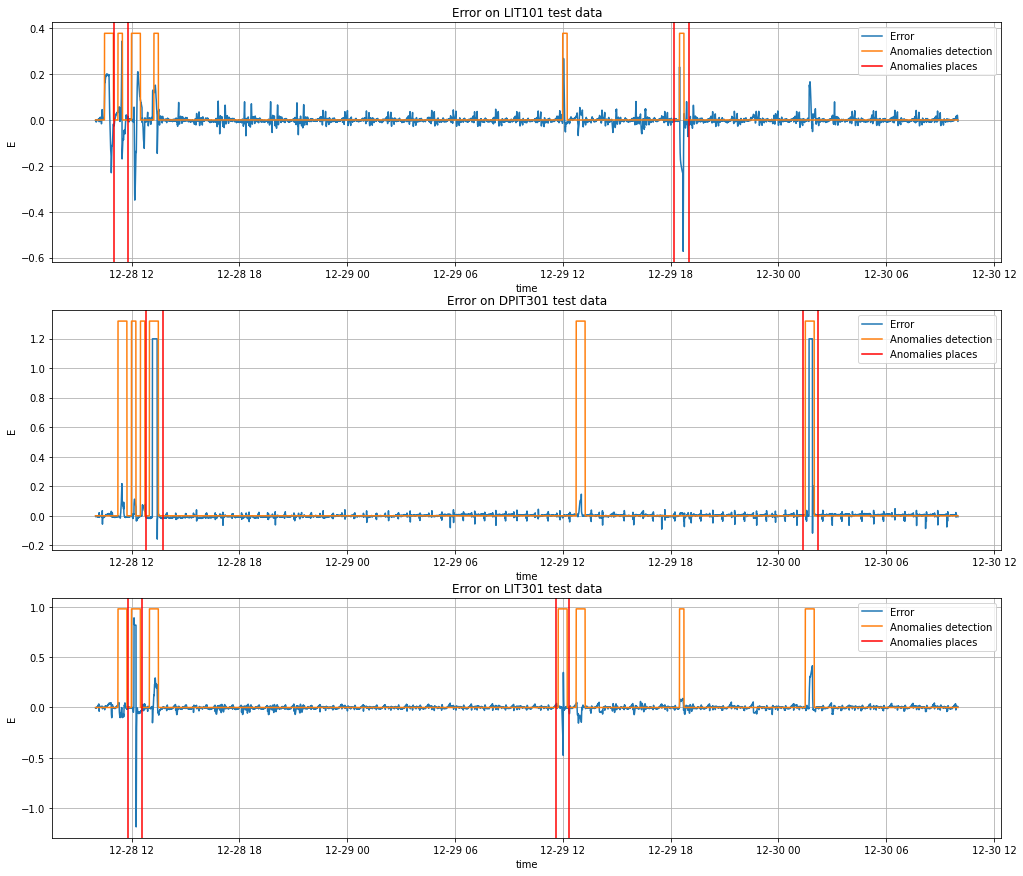

              precision    recall  f1-score   support

      Anomal       0.17      1.00      0.29        40
      Normal       1.00      0.97      0.98      5720

    accuracy                           0.97      5760
   macro avg       0.58      0.98      0.63      5760
weighted avg       0.99      0.97      0.98      5760

              precision    recall  f1-score   support

      Anomal       0.18      1.00      0.31        55
      Normal       1.00      0.96      0.98      5705

    accuracy                           0.96      5760
   macro avg       0.59      0.98      0.64      5760
weighted avg       0.99      0.96      0.97      5760

              precision    recall  f1-score   support

      Anomal       0.06      1.00      0.11        23
      Normal       1.00      0.94      0.97      5737

    accuracy                           0.94      5760
   macro avg       0.53      0.97      0.54      5760
weighted avg       1.00      0.94      0.96      5760



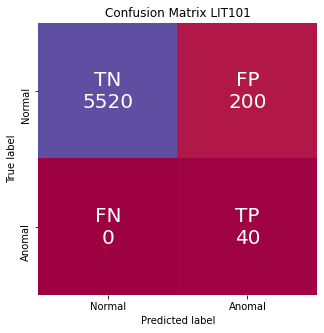

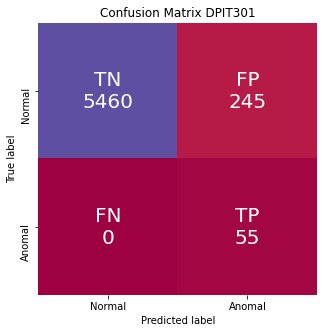

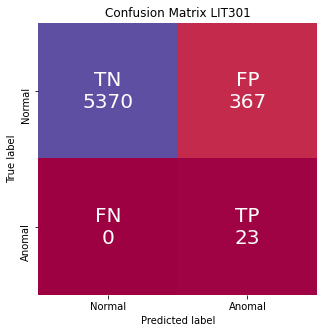

In [11]:
frame_len = 30
k_th = 2
new_len = math.floor(len(error_test)/frame_len) * frame_len
test_signal = np.zeros((new_len, N))
detection = np.zeros((new_len, N))
for i in range(N):
    test_signal[:,i], detection[:,i] = VAD(signal=error_test[:,i], norma=error_train[:,i], frame_len = frame_len, k_th = k_th)

plt.figure(figsize=(17,15))
for i in range(N):
    plt.subplot(311+i)
    plt.plot(test_dataframe.index[:len(test_signal[:,i])], test_signal[:,i])
    plt.plot(test_dataframe.index[:len(test_signal[:,i])], detection[:,i])
    if i == 0:
        for ind in redline_dateindex_1:
            plt.axvline(x=ind,color='r')
    if i == 1:
        for ind in redline_dateindex_2:
            plt.axvline(x=ind,color='r')
    if i == 2:
        for ind in redline_dateindex_3:
            plt.axvline(x=ind,color='r')
    plt.title('Error on '+titles[i]+' test data')
    plt.ylabel('E')
    plt.xlabel('time')
    plt.grid()
    legend_elements = [Line2D([0], [0], color='tab:blue', label='Error'),
                       Line2D([0], [0], color='tab:orange', label='Anomalies detection'),
                       Line2D([0], [0], color='r', label='Anomalies places')]
    plt.legend(handles=legend_elements, loc=1)

plt.savefig(model_directory+'\\'+model_input+'\\test error VAD', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', pad_inches=0.1)
plt.show()


true_labels = labels_dataframe.to_numpy()[:,:-1]
model_labels = np.empty_like(true_labels)
for i in range(error_test.shape[0]):
    for j in range(error_test.shape[1]):
        if abs(error_test[i,j]) > anomal_thresholds[j]:
            model_labels[i,j] = 'Anomal'
        else: 
            model_labels[i,j] = 'Normal'
            
            
true_labels = labels_dataframe.to_numpy()[:len(test_signal)]
model_labels = np.empty_like(true_labels)

for i in range(detection.shape[0]):
    for j in range(detection.shape[1]):
        if detection[i,j] != 0:
            model_labels[i,j] = 'Anomal'
        else:
            model_labels[i,j] = 'Normal'

            
for i in range(N):
    cf_matrix = confusion_matrix(true_labels[:,i], model_labels[:,i], labels = ['Normal','Anomal'])
    make_confusion_matrix(cf_matrix,
                          f_name = model_directory+'\\'+model_input+'\\conf matrix '+titles[i]+' VAD',
                          group_names = ['TN','FP','FN','TP'],
                          categories = ['Normal', 'Anomal'],
                          percent = False,
                          cbar = False,
                          sum_stats = False,
                          cmap = 'Spectral',
                          figsize = (5,5),
                          title = 'Confusion Matrix '+titles[i])
    print(classification_report(true_labels[:,i], model_labels[:,i]))

<h2>Сигнал суммарной ошибки</h2>

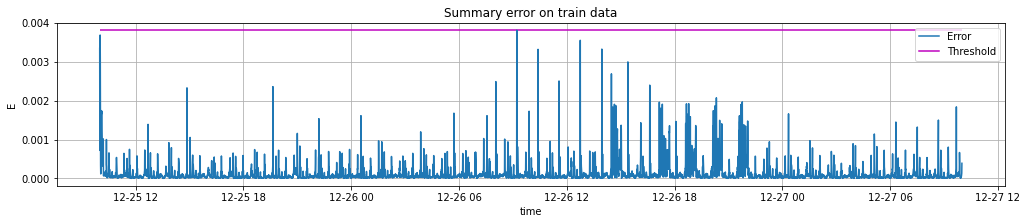

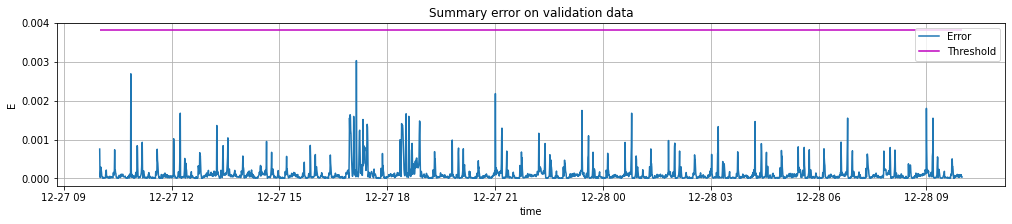

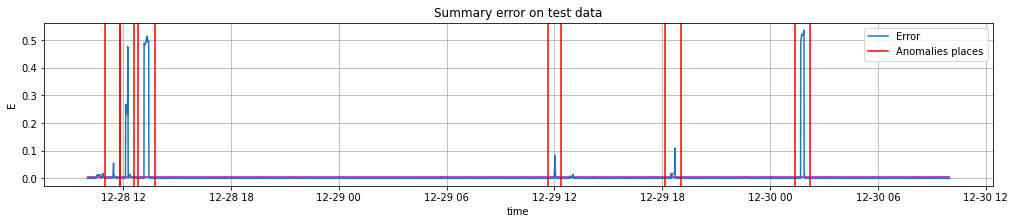

              precision    recall  f1-score   support

      Anomal       0.45      0.87      0.60       118
      Normal       1.00      0.98      0.99      5642

    accuracy                           0.98      5760
   macro avg       0.72      0.93      0.79      5760
weighted avg       0.99      0.98      0.98      5760



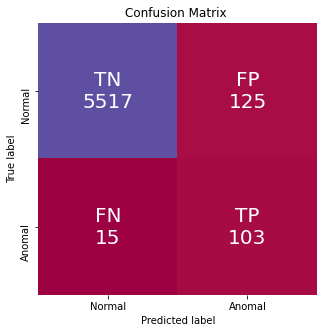

In [12]:
e_train = (1/N) * np.sum(error_train**2, axis = 1)
e_valid = (1/N) * np.sum(error_valid**2, axis = 1)
e_test = (1/N) * np.sum(error_test**2, axis = 1)
anomal_th_sum = max(abs(e_train[10:]))

plt.figure(figsize=(17,3))
plt.plot(train_dataframe.index[:-2880], e_train)
plt.hlines(anomal_th_sum, train_dataframe.index[0],
           train_dataframe.index[-2880], colors = 'm')
#plt.yscale("log")
plt.title('Summary error on train data')
plt.ylabel('E')
plt.xlabel('time')
plt.grid()
legend_elements = [Line2D([0], [0], color='tab:blue', label='Error'),
                   Line2D([0], [0], color='m', label='Threshold')]
plt.legend(handles=legend_elements, loc=1)

plt.savefig(model_directory+'\\'+model_input+'\\summary train error', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', pad_inches=0.1)
plt.show()

plt.figure(figsize=(17,3))
plt.plot(train_dataframe.index[-2880:], e_valid)
plt.hlines(anomal_th_sum, train_dataframe.index[-2880],
           train_dataframe.index[-1], colors = 'm')
#plt.yscale("log")
plt.title('Summary error on validation data')
plt.ylabel('E')
plt.xlabel('time')
plt.grid()
legend_elements = [Line2D([0], [0], color='tab:blue', label='Error'),
                   Line2D([0], [0], color='m', label='Threshold')]
plt.legend(handles=legend_elements, loc=1)

plt.savefig(model_directory+'\\'+model_input+'\\summary valid error', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', pad_inches=0.1)
plt.show()


plt.figure(figsize=(17,3))
plt.plot(test_dataframe.index, e_test)
plt.hlines(anomal_th_sum, test_dataframe.index[0],
           test_dataframe.index[-1], colors = 'm')
for ind in redline_dateindex_1:
    plt.axvline(x=ind,color='r')
for ind in redline_dateindex_2:
    plt.axvline(x=ind,color='r')
for ind in redline_dateindex_3:
    plt.axvline(x=ind,color='r')
#plt.yscale("log")
plt.title('Summary error on test data')
plt.ylabel('E')
plt.xlabel('time')
plt.grid()
legend_elements = [Line2D([0], [0], color='tab:blue', label='Error'),
                   Line2D([0], [0], color='r', label='Anomalies places')]
plt.legend(handles=legend_elements, loc=1)

plt.savefig(model_directory+'\\'+model_input+'\\summary test error', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', pad_inches=0.1)
plt.show()

sum_labels = labels_dataframe.to_numpy()[:,-1]
model_labels = np.empty_like(sum_labels)
for i in range(e_test.shape[0]):
    if abs(e_test[i]) > anomal_th_sum:
        model_labels[i] = 'Anomal'
    else: 
        model_labels[i] = 'Normal'


cf_matrix = confusion_matrix(sum_labels, model_labels, labels = ['Normal','Anomal'])
make_confusion_matrix(cf_matrix,
                      f_name = model_directory+'\\'+model_input+'\\sum conf matrix ',
                      group_names = ['TN','FP','FN','TP'],
                      categories = ['Normal', 'Anomal'],
                      percent = False,
                      cbar = False,
                      sum_stats = False,
                      cmap = 'Spectral',
                      figsize = (5,5),
                      title = 'Confusion Matrix ')
print(classification_report(sum_labels, model_labels))

<h2>Применение VAD к сигналу суммарной ошибки</h2>

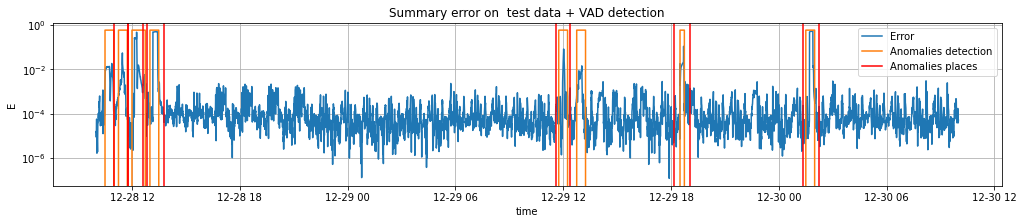

              precision    recall  f1-score   support

      Anomal       0.25      1.00      0.39       118
      Normal       1.00      0.94      0.97      5642

    accuracy                           0.94      5760
   macro avg       0.62      0.97      0.68      5760
weighted avg       0.98      0.94      0.96      5760



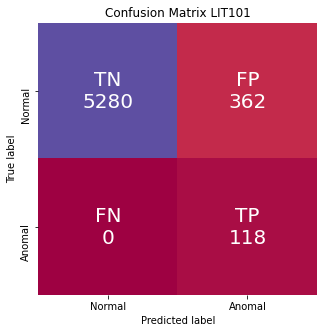

In [36]:
sum_error, sum_detection = VAD(signal=e_test, norma=e_train, frame_len = 30, k_th = 2)

plt.figure(figsize=(17,3))
plt.plot(test_dataframe.index[:len(sum_error)], sum_error)
plt.plot(test_dataframe.index[:len(sum_error)], sum_detection)
for ind in redline_dateindex_1:
    plt.axvline(x=ind,color='r')
for ind in redline_dateindex_2:
    plt.axvline(x=ind,color='r')
for ind in redline_dateindex_3:
    plt.axvline(x=ind,color='r')
plt.yscale("log")
plt.title('Summary error on  test data + VAD detection')
plt.ylabel('E')
plt.xlabel('time')
plt.grid()
legend_elements = [Line2D([0], [0], color='tab:blue', label='Error'),
                   Line2D([0], [0], color='tab:orange', label='Anomalies detection'),
                   Line2D([0], [0], color='r', label='Anomalies places')]
plt.legend(handles=legend_elements, loc=1)

plt.savefig(model_directory+'\\'+model_input+'\\summary test error VAD', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', pad_inches=0.1)
plt.show()

sum_labels = labels_dataframe.to_numpy()[:len(sum_error),-1]
model_labels = np.empty_like(sum_labels)
for i in range(sum_detection.shape[0]):
    if sum_detection[i] != 0:
        model_labels[i] = 'Anomal'
    else: 
        model_labels[i] = 'Normal'

cf_matrix = confusion_matrix(sum_labels, model_labels, labels = ['Normal','Anomal'])
make_confusion_matrix(cf_matrix,
                      f_name = model_directory+'\\'+model_input+'\\sum conf matrix VAD',
                      group_names = ['TN','FP','FN','TP'],
                      categories = ['Normal', 'Anomal'],
                      percent = False,
                      cbar = False,
                      sum_stats = False,
                      cmap = 'Spectral',
                      figsize = (5,5),
                      title = 'Confusion Matrix LIT101')
print(classification_report(sum_labels, model_labels))